# Spatial autocorrelation 
* Guides with codes on https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html
* Here we use data aggregated by CDUID
    * /dataset/canada-census-division/CD-download-data.shp


In [ ]:
# To do:
# Test this with no external boundary data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

!pip install geopandas &> /dev/null
import os
import pandas as pd
import pickle
import geopandas as gpd
import numpy as np


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1HoiIO5rDk02yAPQn_FwLi0Ry7lo64zYp/dataset


Here we perform spatial autocorrelation using the aggregated data.

In [5]:
os.chdir('/content/drive/MyDrive/shared/ssc22-case-comp/dataset/')
print(os.getcwd())

# Load data
dat_path = './canada-census-division/CD-download-data.shp'
dat = gpd.read_file(dat_path)
print(dat.shape)
print(dat.columns)
dat.head(5)

(293, 20)
Index(['CDUID', 'CDNAME', 'CDTYPE', 'PRUID', 'PRNAME', '2019-Q1', '2019-Q2',
       '2019-Q3', '2019-Q4', '2020-Q1', '2020-Q2', '2020-Q3', '2020-Q4',
       '2021-Q1', '2021-Q2', '2021-Q3', '2021-Q4', 'tests', 'DA_POP',
       'geometry'],
      dtype='object')


,CDUID,CDNAME,CDTYPE,PRUID,PRNAME,2019-Q1,2019-Q2,2019-Q3,2019-Q4,2020-Q1,2020-Q2,2020-Q3,2020-Q4,2021-Q1,2021-Q2,2021-Q3,2021-Q4,tests,DA_POP,geometry
0,4621,Division No. 21,CDR,46,Manitoba,10.969708,11.504049,12.178585,11.598048,31.078093,17.680161,32.997536,39.577115,36.638628,68.453336,62.776182,95.403728,9685,1053890.0,"POLYGON ((5753862.131 2114062.380, 5752944.009..."
1,4622,Division No. 22,CDR,46,Manitoba,42.902977,31.102748,31.654955,63.713872,22.245280,25.696649,30.131834,37.165333,66.576610,86.906071,102.148346,97.025587,4389,1096785.0,"POLYGON ((6204057.683 2107140.734, 6204737.266..."
2,4623,Division No. 23,CDR,46,Manitoba,7.367737,8.154834,10.676788,10.329840,18.924137,11.283153,59.781785,69.834849,59.428820,77.856268,93.372450,97.945121,3235,266635.0,"MULTIPOLYGON (((6039656.509 2636304.343, 60396..."
3,4701,Division No. 1,CDR,47,Saskatchewan,14.791119,14.680140,19.249345,23.091277,21.493342,18.430462,16.796906,21.772634,22.333091,49.550688,79.115720,67.320231,17296,1741640.0,"POLYGON ((5422081.934 1612417.386, 5422521.154..."
4,4702,Division No. 2,CDR,47,Saskatchewan,16.695685,20.033315,21.169976,23.188939,23.552589,21.423277,24.913625,23.100039,21.547493,31.417196,51.642854,50.141588,11089,1076270.0,"POLYGON ((5270212.334 1641442.671, 5270216.591..."


In [7]:
!pip install pysal contextily &> /dev/null
import matplotlib.pyplot as plt
import seaborn
from pysal.viz import splot
from splot.esda import plot_moran
import contextily

import geopandas as gpd
import pandas as pd
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed


In [8]:
dat.info() ## it looks like there are still null values.

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   CDUID     293 non-null    object  
 1   CDNAME    293 non-null    object  
 2   CDTYPE    293 non-null    object  
 3   PRUID     293 non-null    object  
 4   PRNAME    293 non-null    object  
 5   2019-Q1   290 non-null    float64 
 6   2019-Q2   290 non-null    float64 
 7   2019-Q3   290 non-null    float64 
 8   2019-Q4   290 non-null    float64 
 9   2020-Q1   291 non-null    float64 
 10  2020-Q2   291 non-null    float64 
 11  2020-Q3   290 non-null    float64 
 12  2020-Q4   291 non-null    float64 
 13  2021-Q1   291 non-null    float64 
 14  2021-Q2   291 non-null    float64 
 15  2021-Q3   291 non-null    float64 
 16  2021-Q4   291 non-null    float64 
 17  tests     293 non-null    int64   
 18  DA_POP    293 non-null    float64 
 19  geometry  293 non-null    geometry
dtypes:

In [22]:
inds = np.unique(np.where(pd.isnull(dat))[0])
dat.loc[inds]

,CDUID,CDNAME,CDTYPE,PRUID,PRNAME,2019-Q1,2019-Q2,2019-Q3,2019-Q4,2020-Q1,2020-Q2,2020-Q3,2020-Q4,2021-Q1,2021-Q2,2021-Q3,2021-Q4,tests,DA_POP,geometry
281,5957,Stikine,REG,59,British Columbia / Colombie-Britannique,13.064,4.751,18.7705,NaN,14.289333,14.134077,10.716212,14.535333,9.864000,5.536550,13.15300,7.820800,138,2690.0,"POLYGON ((4018904.414 3410247.271, 4019429.869..."
290,6204,Baffin,REG,62,Nunavut,NaN,NaN,NaN,53.06,32.034000,NaN,NaN,NaN,15.615333,8.527091,7.61125,14.778941,102,85875.0,"MULTIPOLYGON (((7020343.300 3239921.443, 70203..."
291,6205,Keewatin,REG,62,Nunavut,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,3535.0,"MULTIPOLYGON (((6193825.809 3390255.469, 61943..."
292,6208,Kitikmeot,REG,62,Nunavut,NaN,NaN,NaN,NaN,NaN,3.920000,NaN,17.948000,NaN,NaN,NaN,NaN,2,0.0,"MULTIPOLYGON (((6105932.626 3935743.411, 61062..."


In [23]:
cond = dat['PRNAME']=='Nunavut'
dat[cond]

,CDUID,CDNAME,CDTYPE,PRUID,PRNAME,2019-Q1,2019-Q2,2019-Q3,2019-Q4,2020-Q1,2020-Q2,2020-Q3,2020-Q4,2021-Q1,2021-Q2,2021-Q3,2021-Q4,tests,DA_POP,geometry
290,6204,Baffin,REG,62,Nunavut,NaN,NaN,NaN,53.06,32.034,NaN,NaN,NaN,15.615333,8.527091,7.61125,14.778941,102,85875.0,"MULTIPOLYGON (((7020343.300 3239921.443, 70203..."
291,6205,Keewatin,REG,62,Nunavut,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,3535.0,"MULTIPOLYGON (((6193825.809 3390255.469, 61943..."
292,6208,Kitikmeot,REG,62,Nunavut,NaN,NaN,NaN,NaN,NaN,3.92,NaN,17.948,NaN,NaN,NaN,NaN,2,0.0,"MULTIPOLYGON (((6105932.626 3935743.411, 61062..."


In [26]:
with open('./python_canada-speed-data.p', 'rb') as file:
  canada = pickle.load(file)

In [27]:
dat2 = dat.drop(inds)

(289, 20)

In [28]:
dat2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 289 entries, 0 to 289
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   CDUID     289 non-null    object  
 1   CDNAME    289 non-null    object  
 2   CDTYPE    289 non-null    object  
 3   PRUID     289 non-null    object  
 4   PRNAME    289 non-null    object  
 5   2019-Q1   289 non-null    float64 
 6   2019-Q2   289 non-null    float64 
 7   2019-Q3   289 non-null    float64 
 8   2019-Q4   289 non-null    float64 
 9   2020-Q1   289 non-null    float64 
 10  2020-Q2   289 non-null    float64 
 11  2020-Q3   289 non-null    float64 
 12  2020-Q4   289 non-null    float64 
 13  2021-Q1   289 non-null    float64 
 14  2021-Q2   289 non-null    float64 
 15  2021-Q3   289 non-null    float64 
 16  2021-Q4   289 non-null    float64 
 17  tests     289 non-null    int64   
 18  DA_POP    289 non-null    float64 
 19  geometry  289 non-null    geometry
dtypes:

In [50]:
cols = np.append(np.array(dat2.columns[range(5,17)]), dat2.columns[19])
cols

array(['2019-Q1', '2019-Q2', '2019-Q3', '2019-Q4', '2020-Q1', '2020-Q2',
       '2020-Q3', '2020-Q4', '2021-Q1', '2021-Q2', '2021-Q3', '2021-Q4',
       'geometry'], dtype=object)

In [61]:
sub_dat = dat[cols]
# sub_dat = dat2[cols]
sub_dat.head()

,2019-Q1,2019-Q2,2019-Q3,2019-Q4,2020-Q1,2020-Q2,2020-Q3,2020-Q4,2021-Q1,2021-Q2,2021-Q3,2021-Q4,geometry
0,10.969708,11.504049,12.178585,11.598048,31.078093,17.680161,32.997536,39.577115,36.638628,68.453336,62.776182,95.403728,"POLYGON ((5753862.131 2114062.380, 5752944.009..."
1,42.902977,31.102748,31.654955,63.713872,22.245280,25.696649,30.131834,37.165333,66.576610,86.906071,102.148346,97.025587,"POLYGON ((6204057.683 2107140.734, 6204737.266..."
2,7.367737,8.154834,10.676788,10.329840,18.924137,11.283153,59.781785,69.834849,59.428820,77.856268,93.372450,97.945121,"MULTIPOLYGON (((6039656.509 2636304.343, 60396..."
3,14.791119,14.680140,19.249345,23.091277,21.493342,18.430462,16.796906,21.772634,22.333091,49.550688,79.115720,67.320231,"POLYGON ((5422081.934 1612417.386, 5422521.154..."
4,16.695685,20.033315,21.169976,23.188939,23.552589,21.423277,24.913625,23.100039,21.547493,31.417196,51.642854,50.141588,"POLYGON ((5270212.334 1641442.671, 5270216.591..."


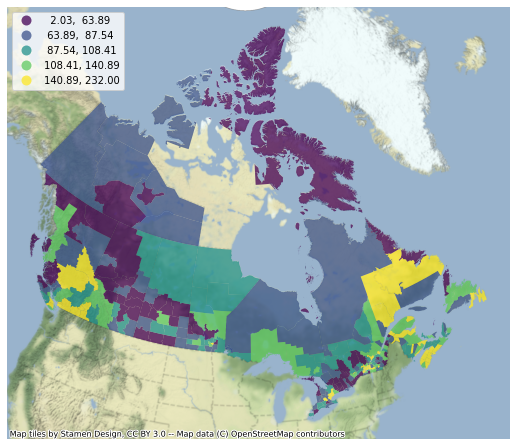

In [62]:
f, ax = plt.subplots(1, figsize=(9,9))
sub_dat.plot(column = '2021-Q4',
             cmap='viridis',
             scheme='quantiles',
             k=5,
             edgecolor='white',
             linewidth=0,
             alpha=0.75,
             legend=True,
             legend_kwds={'loc':2},
             ax=ax)

contextily.add_basemap(ax, 
                       crs=sub_dat.crs, 
                       source=contextily.providers.Stamen.TerrainBackground
                      )
ax.set_axis_off()

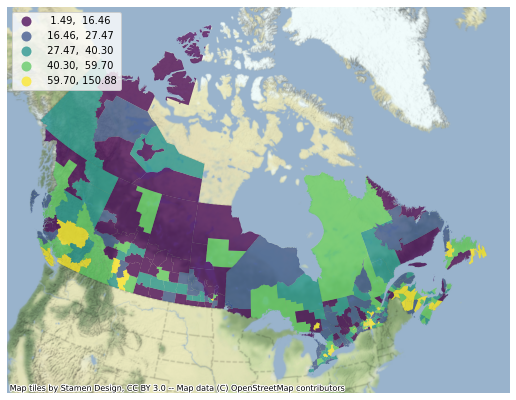

In [63]:
f, ax = plt.subplots(1, figsize=(9,9))
sub_dat.plot(column = '2019-Q1',
             cmap='viridis',
             scheme='quantiles',
             k=5,
             edgecolor='white',
             linewidth=0,
             alpha=0.75,
             legend=True,
             legend_kwds={'loc':2},
             ax=ax)

contextily.add_basemap(ax, 
                       crs=sub_dat.crs, 
                       source=contextily.providers.Stamen.TerrainBackground
                      )
ax.set_axis_off()

In [64]:
# Global autocorrelation
# Smooths out the borders

w = weights.KNN.from_dataframe(sub_dat, k=8)
w.transform = 'R' # row-standardization

sub_dat['2021-Q4_lag'] = weights.spatial_lag.lag_spatial(w, sub_dat['2021-Q4'])

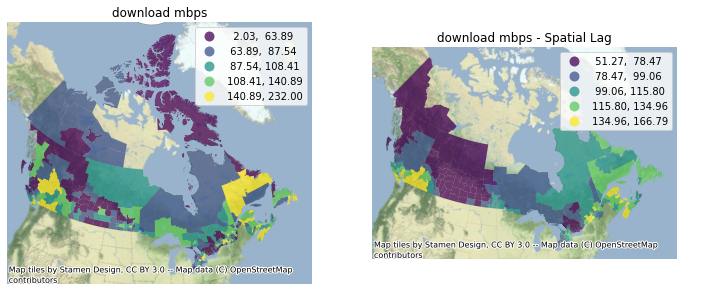

In [65]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = axs

sub_dat.plot(column='2021-Q4', cmap='viridis', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0., alpha=0.75, legend=True, ax=ax1)
ax1.set_axis_off()
ax1.set_title("download mbps")
contextily.add_basemap(ax1, 
                       crs=sub_dat.crs, 
                       source=contextily.providers.Stamen.TerrainBackground,
                       
                      )

sub_dat.plot(column='2021-Q4_lag', cmap='viridis', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0., alpha=0.75, legend=True, ax=ax2)
ax2.set_axis_off()
ax2.set_title("download mbps - Spatial Lag")
contextily.add_basemap(ax2, 
                       crs=sub_dat.crs, 
                       source=contextily.providers.Stamen.TerrainBackground,
                       
                      )

plt.show()

In [66]:
# binary case: mbps < 50

sub_dat['slow'] = (sub_dat['2021-Q4'] < 50).astype(int)
sub_dat[['2021-Q4', 'slow']].tail()

,2021-Q4,slow
288,87.262300,0
289,78.829696,0
290,14.778941,1
291,NaN,0
292,NaN,0


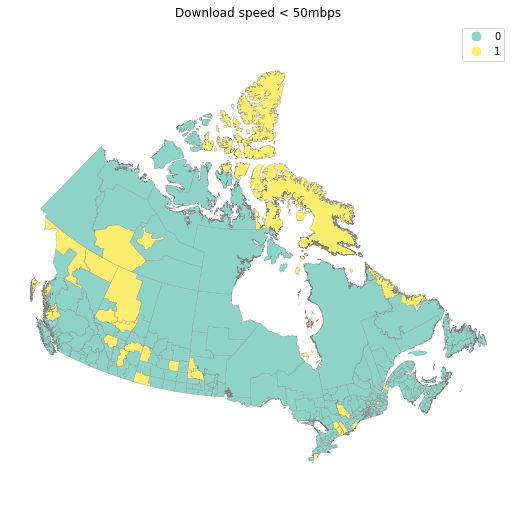

In [67]:
f, ax = plt.subplots(1, figsize=(9, 9))
sub_dat.plot(ax=ax, column='slow', categorical=True, legend=True, 
        edgecolor='0.5', linewidth=0.25, cmap='Set3', 
        figsize=(9, 9));
ax.set_axis_off()
ax.set_title('Download speed < 50mbps')
plt.axis('equal')
plt.show()